Data shape: N=20, T=2811, F=2
Data_x shape: (2788, 12, 20, 2), Data_y shape: (2788, 12, 20, 2), Mask_y shape: (2788, 12, 20)
(1, 12, 20, 2)
[15.57860528 17.47151793 18.2110435  18.51756452 18.4520752  17.53146584
 18.05150531 17.31957495 17.74653433 16.28833127 15.72365056 16.34738791]
[14.00000262 14.00000262 12.9999923  11.99998199 11.99998199 11.00001042
 11.00001042 10.00000011 10.00000011 10.00000011  8.99998979  8.99998979]


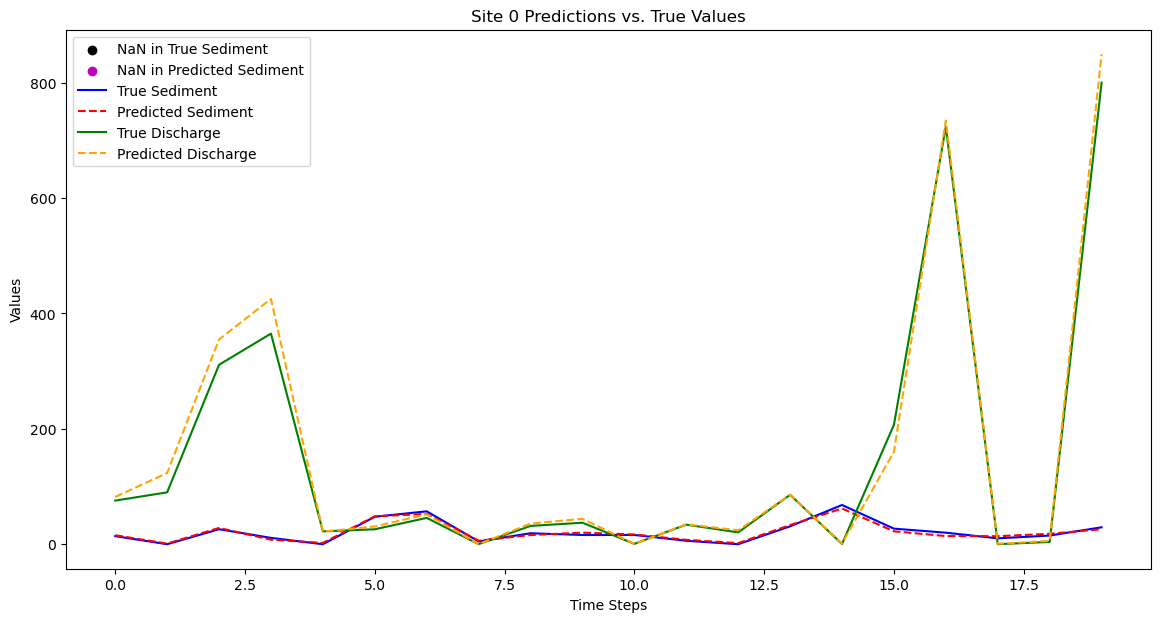

In [22]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from ST_Encoder import ST_Enc
from args import parse_args
from torch.utils.data import DataLoader, TensorDataset

# 解析参数
args = parse_args()

# 加载数据集
data = np.load('/home/zhangmin/toby/UrbanGPT/data/discharge/data_encoder.npy')
N, T, F = data.shape
print(f"Data shape: N={N}, T={T}, F={F}")

# 计算数据的均值和标准差，并进行标准化处理
data_mean = np.nanmean(data, axis=(1, 2), keepdims=True)
data_std = np.nanstd(data, axis=(1, 2), keepdims=True)
data_std[data_std == 0] = 1  # 防止除以零
data = (data - data_mean) / data_std

input_window = args.input_window
output_window = args.output_window

# 创建输入和输出数据及其掩码
data_x = []
data_y = []
mask_y = []

for t in range(T - input_window - output_window + 1):
    x = data[:, t:t+input_window, :].transpose(1, 0, 2)
    y = data[:, t+input_window:t+input_window+output_window, :].transpose(1, 0, 2)
    mask_y.append(~np.isnan(data[:, t+input_window:t+input_window+output_window, 0].transpose(1, 0)))
    data_x.append(x)
    data_y.append(y)

data_x = np.array(data_x)
data_y = np.array(data_y)
mask_y = np.array(mask_y)

print(f"Data_x shape: {data_x.shape}, Data_y shape: {data_y.shape}, Mask_y shape: {mask_y.shape}")

assert data_x.shape[1] == input_window, f"input sequence length not equal to preset sequence length, expected {input_window}, but got {data_x.shape[1]}"

data_x = torch.tensor(data_x, dtype=torch.float32)
data_y = torch.tensor(data_y, dtype=torch.float32)
mask_y = torch.tensor(mask_y, dtype=torch.float32)

eval_dataset = TensorDataset(data_x, data_y, mask_y)
eval_loader = DataLoader(eval_dataset, batch_size=1, shuffle=True)

model = ST_Enc(args, dim_in=F, dim_out=args.output_dim).to('cuda')
checkpoint_path = '/home/zhangmin/toby/UrbanGPT/checkpoints/st_encoder/pretrain_stencoder.pth'
model.load_state_dict(torch.load(checkpoint_path))
model.eval()


def inverse_transform(data, mean, std):
    mean = mean.squeeze()
    std = std.squeeze()
    mean = mean[np.newaxis, np.newaxis, :, np.newaxis]
    std = std[np.newaxis, np.newaxis, :, np.newaxis]
    return data * std + mean


def plot_predictions_vs_true_with_nan(sample_y, predicted_y, mask_y, time_steps, site_index=0):
    plt.figure(figsize=(14, 7))

    true_sediment = sample_y[0, site_index, :, 0]
    predicted_sediment = predicted_y[0, site_index, :, 0]

    true_discharge = sample_y[0, site_index, :, 1]
    predicted_discharge = predicted_y[0, site_index, :, 1]

    nan_mask_sediment = np.array(mask_y[0, site_index, :], dtype=bool)

    plt.scatter(time_steps[~nan_mask_sediment], true_sediment[~nan_mask_sediment], color='k', label='NaN in True Sediment')
    plt.scatter(time_steps[~nan_mask_sediment], predicted_sediment[~nan_mask_sediment], color='m', label='NaN in Predicted Sediment')

    plt.plot(time_steps, true_sediment, label='True Sediment', color='b')
    plt.plot(time_steps, predicted_sediment, label='Predicted Sediment', color='r', linestyle='--')
    plt.plot(time_steps, true_discharge, label='True Discharge', color='g')
    plt.plot(time_steps, predicted_discharge, label='Predicted Discharge', color='orange', linestyle='--')
    plt.xlabel('Time Steps')
    plt.ylabel('Values')
    plt.title(f'Site {site_index} Predictions vs. True Values')
    plt.legend()
    plt.show()


with torch.no_grad():
    for sample_x, sample_y, mask_y in eval_loader:
        sample_x, sample_y, mask_y = sample_x.to('cuda'), sample_y.to('cuda'), mask_y.to('cuda')
        predicted_y, _ = model(sample_x)
        predicted_y = predicted_y.cpu().numpy()
        sample_y = sample_y.cpu().numpy()
        mask_y = mask_y.cpu().numpy()
        predicted_y = inverse_transform(predicted_y, data_mean, data_std)
        sample_y = inverse_transform(sample_y, data_mean, data_std)

        print(predicted_y.shape)
        print(predicted_y[0, :, 0, 0])
        print(sample_y[0, :, 0, 0])

        time_steps = np.arange(len(sample_y[0, 0, :, 0]))  # 时间轴
        plot_predictions_vs_true_with_nan(sample_y, predicted_y, mask_y, time_steps)
        break